<a href="https://colab.research.google.com/github/Geek-a-Byte/Federated-Learning-Aided-Cervical-Cancer-Classification/blob/main/pre-defence/Cervical_Cancer_Classification_Using_CNN_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and Required Imports

In [ ]:
!pip uninstall syft
!pip install syft==0.2.9

In [ ]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall Pillow
# install the new one
!pip install Pillow==5.3.0

In [1]:
# import the new one
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [2]:
# since the input images are quite large, we will disable the size check
PIL.Image.MAX_IMAGE_PIXELS = None

In [3]:
!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Imports here
import cv2
import shutil 
import os
import time
from collections import OrderedDict
from datetime import datetime
from pytz import timezone  
import copy

import torch
torch.cuda.empty_cache()

import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Loading and Formatting the dataset

### [**dataset link**](https://drive.google.com/file/d/1nc-ua-1jMrui428ZMO5cDt7skUMilnMY/view?usp=sharing)



In [ ]:
!unzip "/content/drive/MyDrive/CervicalCancerSplitDataset.zip" -d "./CervicalCancerSplitDataset/"

###### after keeping val_ratio = 0.15, test_ratio = 0.15 we get 

| Class Name               | Total images   | Training | Validation | Testing |
|--------------------------|----------------|----------|------------|---------|
| Dyskeratotic             | 813            |  569     |  122       | 122     |
| Koilocytotic             | 825            | 577      | 124        | 124     |
| Metaplastic              | 793            | 555      | 119        | 119     |
| Parabasal                | 787            | 550      | 118        | 119     |
| Superficial-Intermediate | 831            | 581      | 125        | 125     |

In [9]:
import os
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
num_of_image = {}
for cls in classes:
    # Counting the Number of Files in the Folder
    lst_test = os.listdir('/content/CervicalCancerSplitDataset/content/CervicalCancerSplitDataset/test/'+cls) # your directory path
    lst_train = os.listdir('/content/CervicalCancerSplitDataset/content/CervicalCancerSplitDataset/train/'+cls)
    lst_valid = os.listdir('/content/CervicalCancerSplitDataset/content/CervicalCancerSplitDataset/valid/'+cls)
    number_files_test = len(lst_test)
    number_files_train = len(lst_train)
    number_files_valid = len(lst_valid)
    num_of_image[cls] = number_files_test+number_files_train+number_files_valid


print(num_of_image)

{'Dyskeratotic': 813, 'Koilocytotic': 825, 'Metaplastic': 793, 'Parabasal': 787, 'Superficial-Intermediate': 831}


## Creating Dataloaders

We first load the data and transform the training Dataset into a Federated Dataset to send the worker clients. This federated dataset is now given to a Federated DataLoader which will iterate over remote batches.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
data_dir = '/content/CervicalCancerSplitDataset/content/CervicalCancerSplitDataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ", device)

selected:  cuda


In [12]:
# set timezone
my_timezone = timezone('Asia/Dhaka')

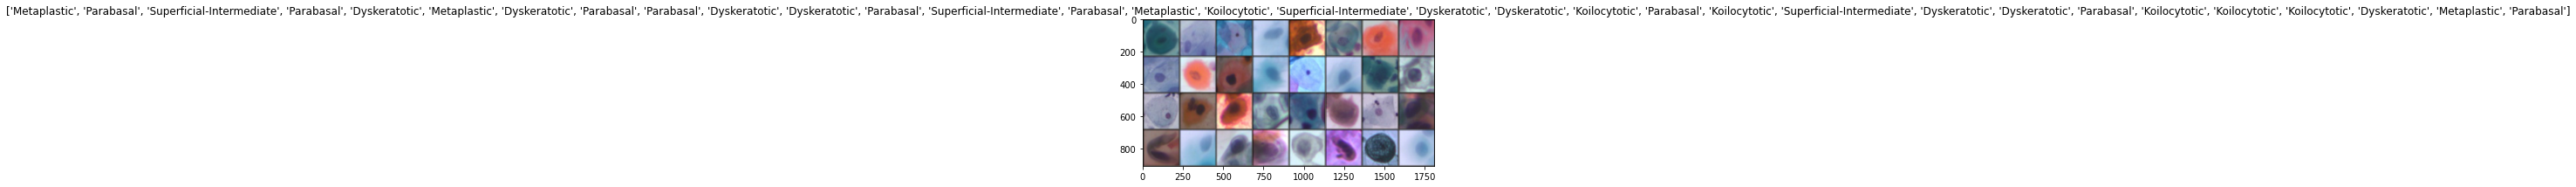

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Building and training the classifier

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} at {}'.format(epoch, num_epochs - 1, datetime.now(my_timezone).strftime('%I:%M:%S %p (%d %b %Y)')))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs[1:].float()
                # inputs[1]+=1;
                inputs = inputs.to(device)
                labels = labels.to(device)

                # debug
                # print("Dimension of inputs tensor:", inputs.dim())
                # print("Inputs tensor Size:\n",inputs.size())
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# super simplified
model = models.densenet121(pretrained=True)

for param in model.parameters():
  param.requires_grad = True

model.classifier = nn.Linear(1024, 5)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [18]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## non_federated_cervical_cancer_cnn model training

In [19]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4 at 02:14:06 PM (01 Oct 2022)
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5418 Acc: 0.8097
valid Loss: 0.3584 Acc: 0.8931
Epoch 1/4 at 02:14:39 PM (01 Oct 2022)
----------
train Loss: 0.2576 Acc: 0.9103
valid Loss: 0.2178 Acc: 0.9194
Epoch 2/4 at 02:15:13 PM (01 Oct 2022)
----------
train Loss: 0.1037 Acc: 0.9622
valid Loss: 0.1177 Acc: 0.9572
Epoch 3/4 at 02:15:47 PM (01 Oct 2022)
----------
train Loss: 0.0714 Acc: 0.9778
valid Loss: 0.1064 Acc: 0.9655
Epoch 4/4 at 02:16:21 PM (01 Oct 2022)
----------
train Loss: 0.0571 Acc: 0.9809
valid Loss: 0.1018 Acc: 0.9688
Training complete in 2m 50s
Best val Acc: 0.968750


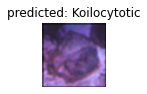

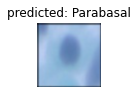

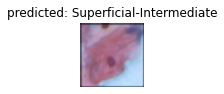

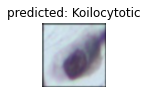

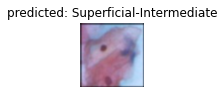

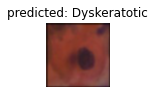

In [20]:
visualize_model(model)

## Save the non_federated_cervical_cancer_cnn model

In [21]:
torch.save(model.state_dict(), "non_federated_cervical_cancer_cnn.pt")

## Load the model for federated training (ekhan theke code kaj kore na :"))

In [24]:
# super simplified
model = models.densenet121(pretrained=True)

for param in model.parameters():
  param.requires_grad = True

model.classifier = nn.Linear(1024, 5)
model = model.to(device)

In [ ]:
# not needed now. 
# model.load_state_dict(torch.load('/content/drive/MyDrive/non_federated_cervical_cancer_cnn (1).pt'))
# model

## Federated Learning Initial Setup

In [25]:
import syft as sy
hook = sy.TorchHook(torch)

In [26]:
hospital_1 = sy.VirtualWorker(hook, id="hospital_1")
hospital_2 = sy.VirtualWorker(hook, id="hospital_2")

In [27]:
print("hospital_1 has: " + str(hospital_1._objects))
print("hospital_2 has: " + str(hospital_2._objects))

hospital_1 has: {}
hospital_2 has: {}


In [28]:
hospital_1.clear_objects()
hospital_2.clear_objects()

<VirtualWorker id:hospital_2 #objects:0>

In [29]:
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 32
        self.epochs = 4
        self.lr = 0.006
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()
torch.manual_seed(args.seed)

In [30]:
train_data = image_datasets['train']
train_data.data = train_data.imgs

## practise code on MNIST

In [52]:
jake = sy.VirtualWorker(hook, id="jake")
john = sy.VirtualWorker(hook, id="john")

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

train_set = datasets.MNIST(
    "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)

federated_train_loader = sy.FederatedDataLoader(
    train_set.federate((jake,john)), batch_size=64, shuffle=True)

for inputs, labels in federated_train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # debug
    print("Dimension of inputs tensor:", inputs.dim())
    print("Inputs tensor Size:\n",inputs.size())
    # print("x: " + str(x))
    # print("Jake has: " + str(jake._objects))
    print(inputs)
    print(labels)

KeyboardInterrupt: ignored

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
import torch.nn.functional as F

In [ ]:
for epoch in range(0, 5):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        # send the model to the client device where the data is present
        model.send(data.location)
        # training the model
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # get back the improved model
        model.get()
        if batch_idx % 100 == 0:
            # get back the loss
            loss = loss.get()
            print('Epoch: {:2d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                batch_idx * 64,
                len(federated_train_loader) * 64,
                100. * batch_idx / len(federated_train_loader),
                loss.item()))

## On cervical cancer dataset

In [31]:
federated_train_loader = sy.FederatedDataLoader(train_data.federate((hospital_1, hospital_2)), batch_size=args.batch_size, shuffle=True)

## debug code

In [ ]:
for inputs, labels in dataloaders['train']:
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    
    # debug
    print("Dimension of inputs tensor:", inputs.dim())
    print("Inputs tensor Size:\n",inputs.size())
    print(inputs)
    print(labels)

In [ ]:
for inputs, labels in federated_train_loader:
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    
    # debug
    print("Dimension of inputs tensor:", inputs.dim())
    print("Inputs tensor Size:\n",inputs.size())
    # print("x: " + str(x))
    # print("Jake has: " + str(jake._objects))
    print(inputs)
    print(labels)

## Federated Training

In [32]:
torch.cuda.empty_cache()

In [33]:
dataloaders['train'] = federated_train_loader

In [34]:
dataloaders['train']

In [35]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4 at 01:17:39 PM (01 Oct 2022)
----------
Dimension of inputs tensor: 4
Inputs tensor Size:
 torch.Size([0])


RuntimeError: ignored

In [ ]:
visualize_model(model)

## Save the federated_cervical_cancer_cnn model

In [ ]:
torch.save(model.state_dict(), "federated_cervical_cancer_cnn.pt")